In [1]:
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline
%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# for auto-reloading external modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.autograd import Variable
from torch.utils.data import sampler
from torch.utils.data import DataLoader

import torchvision.datasets as dset
import torchvision.transforms as T

import timeit

import models
import solver
import views

# Basic Configuration

In [3]:
dtype = torch.FloatTensor
if torch.cuda.is_available():
    dtype = torch.cuda.FloatTensor

print_every = 100

def reset(m):
    if hasattr(m, 'reset_parameters'):
        m.reset_parameters()
    
    
def show_solver_training(solver):
    views.show_traning(solver.loss_history, solver.train_acc_history, solver.val_acc_history)

    
def show_mean_and_std_hist(parameters):
    paras = [w.data.cpu().numpy() for w in parameters]
    views.plot_mean_std_hist(paras)

    
def show_conv_layer_weights(conv_weights):
    conv_weights = conv_weights.data.cpu().numpy()
    conv_weights = conv_weights.transpose(0, 2, 3, 1)
    views.show_conv_weights(conv_weights)

    
def compare_solvers_tranings(solvers_with_labels):
    loss_train_val_acc_with_labels = {}
    for label, solver in solvers_with_labels.items():
        loss_train_val_acc_with_labels[label] = (solver.loss_history, solver.train_acc_history, solver.val_acc_history)
    
    views.compare_trainings(loss_train_val_acc_with_labels)


# Load cifar-10 dataset

In [4]:
class ChunkSampler(sampler.Sampler):
    """Samples elements sequentially from some offset.
    Arguments:
        num_samples: # of desired datapoints
        start: offset where we should start selecting from"""
    def __init__(self, num_samples, start=0):
        self.num_samples = num_samples
        self.start = start
        
    def __iter__(self):
        return iter(range(self.start, self.start + self.num_samples))
    
    def __len__(self):
        return self.num_samples
    
NUM_TRAIN = 49000
NUM_VAL = 1000

NUM_TRAIN_SMALL = 64

cifar10_train_small = dset.CIFAR10('../cs231n/datasets/', train=True, download=True, transform=T.ToTensor())
loader_train_small = DataLoader(cifar10_train_small, batch_size=64, sampler=ChunkSampler(NUM_TRAIN_SMALL, 0))

cifar10_train = dset.CIFAR10('../cs231n/datasets/', train=True, download=True, transform=T.ToTensor())
loader_train = DataLoader(cifar10_train, batch_size=64, sampler=ChunkSampler(NUM_TRAIN, 0))

cifar10_val = dset.CIFAR10('../cs231n/datasets/', train=True, download=True, transform=T.ToTensor())
# cifar10_val = cifar10_train # can do this?
loader_val = DataLoader(cifar10_val, batch_size=64, sampler=ChunkSampler(NUM_VAL, NUM_TRAIN))

cifar10_test = dset.CIFAR10('../cs231n/datasets/', train=False, download=True, transform=T.ToTensor())
loader_test = DataLoader(cifar10_test, batch_size=64)

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified


## 1. Train example model

In [5]:
torch.cuda.random.manual_seed(12345)

# model
example_model = models.ExampleNet().type(dtype)
example_loss_fn = nn.CrossEntropyLoss().type(dtype)

#example_optimizer = optim.Adam(example_model.parameters(), lr=1e-5, weight_decay=1e-3)
example_optimizer = optim.SGD(example_model.parameters(), lr=1e-3, momentum=0.9, weight_decay=1e-6)
#example_optimizer = optim.RMSprop(example_model.parameters(), lr=1e-5, weight_decay=1e-6)

#example_exp_lr_scheduler = None
example_exp_lr_scheduler = lr_scheduler.StepLR(example_optimizer, step_size=10, gamma=0.2)

example_solver = solver.ClassificationSolver(loader_train=loader_train, loader_val=loader_val,
                                     model=example_model,
                                     loss_fn=example_loss_fn,
                                     optimizer=example_optimizer,
                                     scheduler=example_exp_lr_scheduler,
                                     dtype=dtype,
                                     num_epochs=10, verbose=True)

example_solver.train()

t = 0, loss = 2.3295
t = 100, loss = 1.7144
t = 200, loss = 1.2707
t = 300, loss = 1.4861
t = 400, loss = 1.3511
t = 500, loss = 1.5286
t = 600, loss = 1.4171
t = 700, loss = 1.3702
(Epoch 0 / 10) train acc: 0.537109; val acc: 0.528000
t = 0, loss = 1.3687
t = 100, loss = 1.1621
t = 200, loss = 0.9049
t = 300, loss = 1.1767
t = 400, loss = 1.2163
t = 500, loss = 1.3511
t = 600, loss = 1.2022
t = 700, loss = 1.1751
(Epoch 1 / 10) train acc: 0.595703; val acc: 0.581000
t = 0, loss = 1.1499
t = 100, loss = 1.0783
t = 200, loss = 0.7718
t = 300, loss = 1.0663
t = 400, loss = 1.1246
t = 500, loss = 1.2399
t = 600, loss = 1.0776
t = 700, loss = 1.0881
(Epoch 2 / 10) train acc: 0.574219; val acc: 0.562000
t = 0, loss = 1.0389
t = 100, loss = 1.0302
t = 200, loss = 0.7327
t = 300, loss = 0.9784
t = 400, loss = 1.0901
t = 500, loss = 1.1739
t = 600, loss = 1.0318
t = 700, loss = 1.0278
(Epoch 3 / 10) train acc: 0.603516; val acc: 0.584000
t = 0, loss = 0.9418
t = 100, loss = 0.9697
t = 200, los

## 2. show training statistics

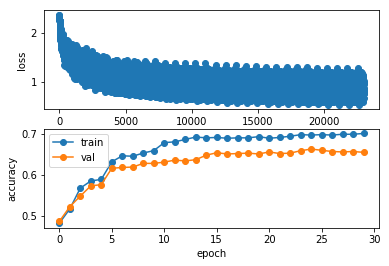

In [6]:
# loss, train_acc_histroy, val_acc_history
show_solver_training(example_solver)

weight index:  0
with size  (32, 3, 7, 7)
with mean: -0.000026, std: 0.042668


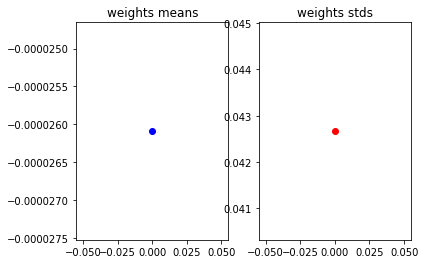

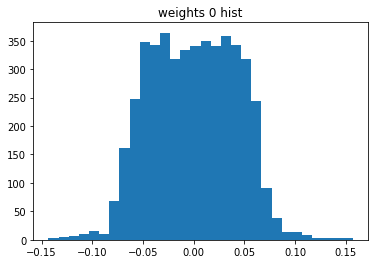

In [7]:
# plot weights mean and std
show_mean_and_std_hist(list(example_model.parameters())[0:1])

net.paras:  ExampleNet(
  (conv): Conv2d(3, 32, kernel_size=(7, 7), stride=(1, 1))
  (relu): ReLU(inplace)
  (bn): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True)
  (max_pool): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), dilation=(1, 1), ceil_mode=False)
  (fc1): Linear(in_features=5408, out_features=1024, bias=True)
  (fc2): Linear(in_features=1024, out_features=10, bias=True)
)


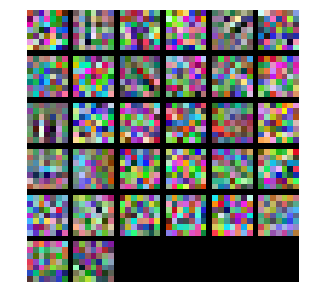

In [8]:
print('net.paras: ', example_model)

# view first conv layer(conv1) weights
show_conv_layer_weights(example_model.conv.weight)

# 2. Train second model

In [9]:
torch.cuda.random.manual_seed(12345)
#example_dropout_model.apply(reset)

# model
example_dropout_model = models.ExampleDropoutNet().type(dtype)
example_dropout_loss_fn = nn.CrossEntropyLoss().type(dtype)

#example_dropout_optimizer = optim.Adam(example_dropout_model.parameters(), lr=1e-3)
example_dropout_optimizer = optim.SGD(example_dropout_model.parameters(), lr=1e-3, momentum=0.9)
#example_dropout_optimizer = optim.SGD(example_dropout_model.parameters(), lr=5e-4, momentum=0.9, weight_decay=2e-4)
#example_dropout_optimizer = optim.RMSprop(example_dropout_model.parameters(), lr=1e-4)

example_dropout_exp_lr_scheduler = None
#example_dropout_exp_lr_scheduler = lr_scheduler.StepLR(example_dropout_optimizer, step_size=5, gamma=0.7)

example_dropout_solver = solver.ClassificationSolver(loader_train=loader_train, loader_val=loader_val,
                                     model=example_dropout_model,
                                     loss_fn=example_dropout_loss_fn,
                                     optimizer=example_dropout_optimizer,
                                     scheduler=example_dropout_exp_lr_scheduler,
                                     dtype=dtype,
                                     num_epochs=10, verbose=True)

example_dropout_solver.train()

t = 0, loss = 2.3031
t = 100, loss = 1.9968
t = 200, loss = 1.5813
t = 300, loss = 1.6875
t = 400, loss = 1.5766
t = 500, loss = 1.6833
t = 600, loss = 1.4760
t = 700, loss = 1.4104
(Epoch 0 / 10) train acc: 0.476562; val acc: 0.459000
t = 0, loss = 1.4157
t = 100, loss = 1.2690
t = 200, loss = 1.1367
t = 300, loss = 1.4515
t = 400, loss = 1.1968
t = 500, loss = 1.5165
t = 600, loss = 1.2436
t = 700, loss = 1.3066
(Epoch 1 / 10) train acc: 0.536133; val acc: 0.517000
t = 0, loss = 1.2558
t = 100, loss = 1.2420
t = 200, loss = 0.9682
t = 300, loss = 1.2956
t = 400, loss = 1.0206
t = 500, loss = 1.4141
t = 600, loss = 1.0847
t = 700, loss = 1.1954
(Epoch 2 / 10) train acc: 0.552734; val acc: 0.524000
t = 0, loss = 1.1327
t = 100, loss = 1.0850
t = 200, loss = 0.8404
t = 300, loss = 1.1913
t = 400, loss = 1.0024
t = 500, loss = 1.3223
t = 600, loss = 1.0304
t = 700, loss = 1.1155
(Epoch 3 / 10) train acc: 0.626953; val acc: 0.590000
t = 0, loss = 1.0558
t = 100, loss = 0.9993
t = 200, los

ExampleDropoutNet(
  (features): Sequential(
    (0): Conv2d(3, 32, kernel_size=(7, 7), stride=(1, 1))
    (1): ReLU(inplace)
    (2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True)
    (3): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), dilation=(1, 1), ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(
    )
    (1): Linear(in_features=5408, out_features=1024, bias=True)
    (2): ReLU(inplace)
    (3): Dropout(p=0.5)
    (4): Linear(in_features=1024, out_features=10, bias=True)
  )
)


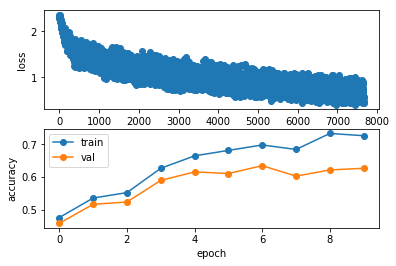

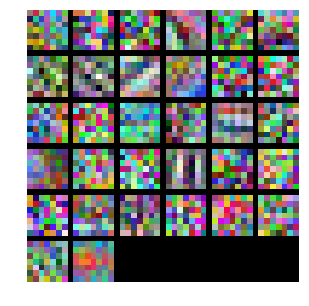

In [10]:
# print net structure
print(example_dropout_model)

# show loss, acc
show_solver_training(example_dropout_solver)

# show first conv layer weight
show_conv_layer_weights(example_dropout_model.features[0].weight)

# 3. Compare two models

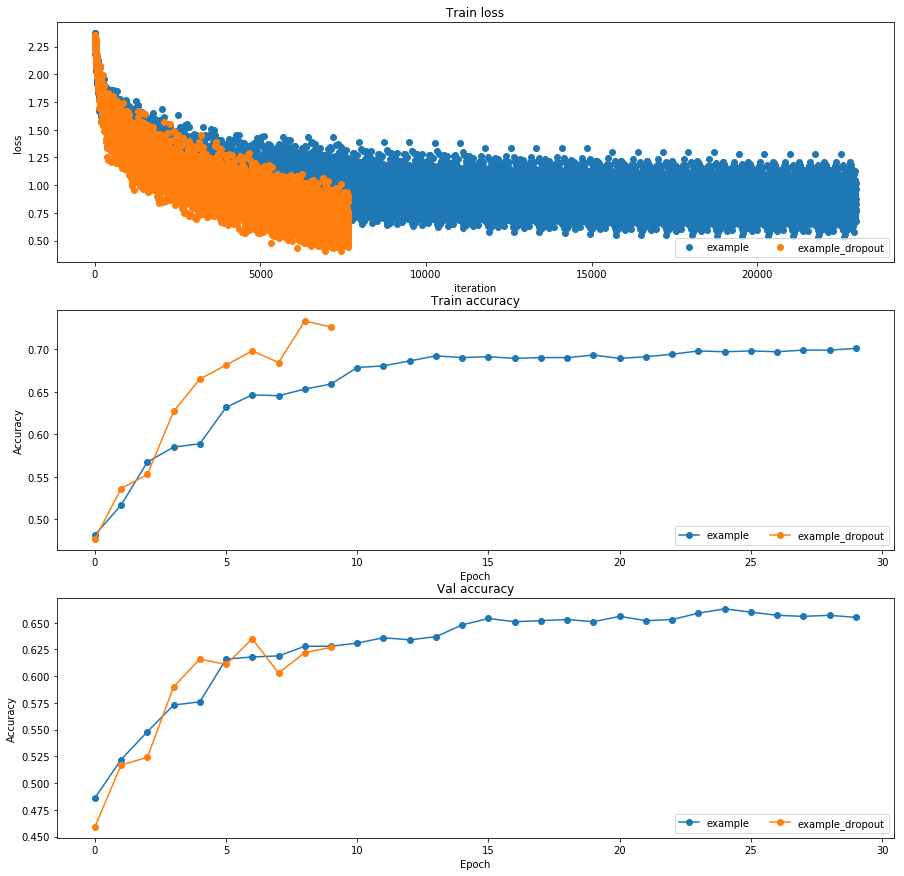

In [11]:
#
compare_solvers_tranings({'example': example_solver, 'example_dropout': example_dropout_solver})

# 3. thrid model

In [12]:
torch.cuda.random.manual_seed(12345)

# model
small_filter_model = models.SmallFilterNet().type(dtype)
small_filter_loss_fn = nn.CrossEntropyLoss().type(dtype)
#small_filter_optimizer = optim.SGD(small_filter_model.parameters(), lr=1e-3, momentum=0.9)

small_filter_optimizer = optim.Adam(small_filter_model.parameters(), lr=1e-4)
#small_filter_scheduler = lr_scheduler.StepLR(small_filter_optimizer, step_size=5, gamma=0.1)

small_filter_solver = solver.ClassificationSolver(loader_train=loader_train, loader_val=loader_val,
                                     model=small_filter_model,
                                     loss_fn=small_filter_loss_fn,
                                     optimizer=small_filter_optimizer,
                                     scheduler=None,
                                     dtype=dtype,
                                     num_epochs=10, verbose=True)

small_filter_solver.train()

t = 0, loss = 2.3175
t = 100, loss = 1.4301
t = 200, loss = 1.0950


KeyboardInterrupt: 

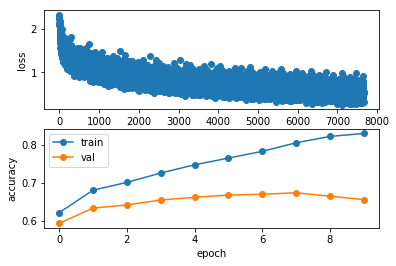

In [13]:
show_solver_training(small_filter_solver)

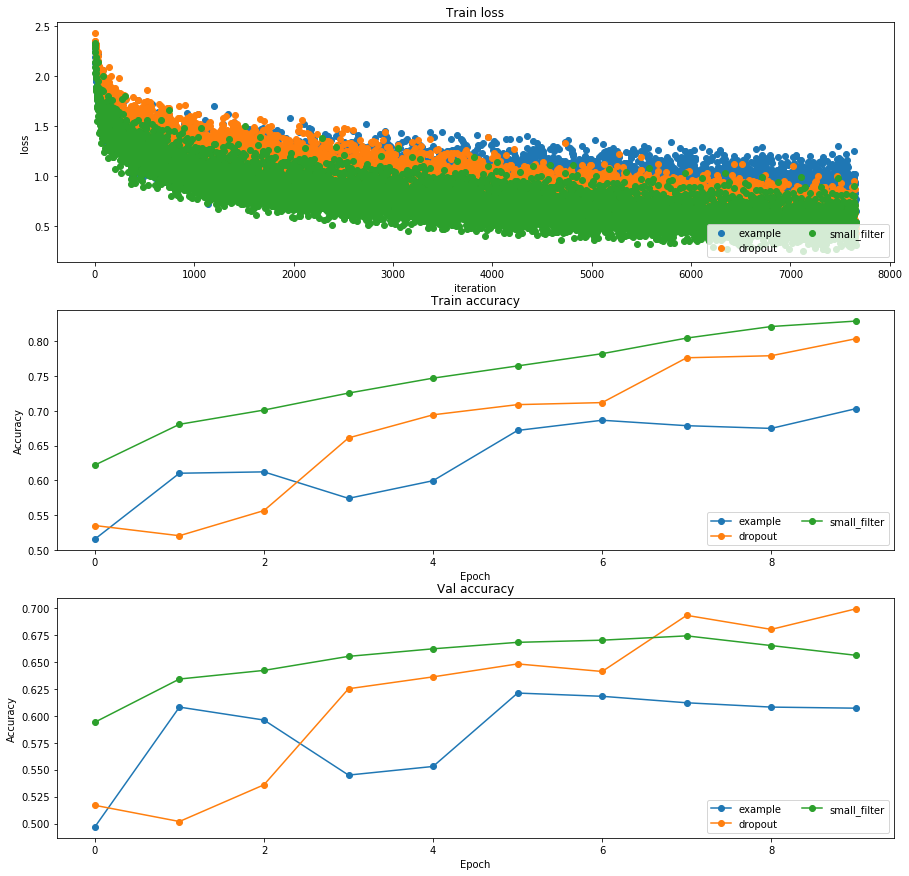

In [14]:
# compre three model trainings
compare_solvers_tranings({'example': example_solver,
                  'dropout': example_dropout_solver,
                  'small_filter': small_filter_solver})

# 4. Cross validation training

## 4.1 example model

In [24]:
# Cross validation

# start with small regularization and find learning rate that makes the loss go down
torch.cuda.random.manual_seed(12345)

# model
#example_model = models.ExampleNet().type(dtype)
example_model.apply(reset)
example_loss_fn = nn.CrossEntropyLoss().type(dtype)

#example_optimizer = optim.Adam(example_model.parameters(), lr=1e-3)
example_optimizer = optim.SGD(example_model.parameters(), lr=1e-5, momentum=0.9, weight_decay=1e-6)
#example_optimizer = optim.RMSprop(example_model.parameters(), lr=5e-5, weight_decay=1e-2)

example_exp_lr_scheduler = None
#example_exp_lr_scheduler = lr_scheduler.StepLR(example_optimizer, step_size=3, gamma=0.5)

example_solver = solver.ClassificationSolver(loader_train=loader_train, loader_val=loader_val,
                                     model=example_model,
                                     loss_fn=example_loss_fn,
                                     optimizer=example_optimizer,
                                     scheduler=example_exp_lr_scheduler,
                                     dtype=dtype,
                                     num_epochs=5, verbose=True)

example_solver.train()


t = 0, loss = 2.3138
t = 100, loss = 2.3238
t = 200, loss = 2.2512
t = 300, loss = 2.2689
t = 400, loss = 2.2524
t = 500, loss = 2.2154
t = 600, loss = 2.2376
t = 700, loss = 2.1710
(Epoch 0 / 5) train acc: 0.236328; val acc: 0.223000
t = 0, loss = 2.2086
t = 100, loss = 2.2108
t = 200, loss = 2.1127
t = 300, loss = 2.1955
t = 400, loss = 2.1473
t = 500, loss = 2.1340
t = 600, loss = 2.1797
t = 700, loss = 2.0674
(Epoch 1 / 5) train acc: 0.299805; val acc: 0.256000
t = 0, loss = 2.1433
t = 100, loss = 2.1445
t = 200, loss = 2.0179
t = 300, loss = 2.1470
t = 400, loss = 2.0872
t = 500, loss = 2.0835
t = 600, loss = 2.1351
t = 700, loss = 1.9963
(Epoch 2 / 5) train acc: 0.311523; val acc: 0.286000
t = 0, loss = 2.1008
t = 100, loss = 2.0910
t = 200, loss = 1.9491
t = 300, loss = 2.1053
t = 400, loss = 2.0490
t = 500, loss = 2.0489
t = 600, loss = 2.1038
t = 700, loss = 1.9375
(Epoch 3 / 5) train acc: 0.327148; val acc: 0.309000
t = 0, loss = 2.0676
t = 100, loss = 2.0466
t = 200, loss = 

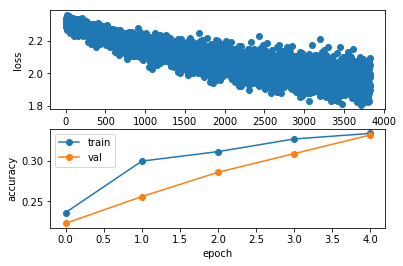

In [25]:
show_solver_training(example_solver)

In [32]:
import numpy as np

train_stats = {}

# model
#example_model = models.ExampleNet().type(dtype)
example_loss_fn = nn.CrossEntropyLoss().type(dtype)

max_count = 100
for count in range(max_count):
    #lr = 10**np.random.uniform(-4, -2)
    lr = 
    reg = 10**np.random.uniform(-6, -3)
    
    # for saving memory?
    example_model.apply(reset)
    example_optimizer = optim.SGD(example_model.parameters(), lr=lr, momentum=0.9, weight_decay=reg)
    example_exp_lr_scheduler = None
    
    example_solver = solver.ClassificationSolver(loader_train=loader_train, loader_val=loader_val,
                                     model=example_model,
                                     loss_fn=example_loss_fn,
                                     optimizer=example_optimizer,
                                     scheduler=example_exp_lr_scheduler,
                                     dtype=dtype,
                                     num_epochs=10, verbose=False)
    example_solver.train()
    train_stats[(lr, reg)] = (example_solver.train_acc_history, example_solver.val_acc_history, example_solver.loss_history)
    print('val accuracy: %f, train accuracy: %f, final loss: %f, lr: %f, reg: %f' % (
        example_solver.val_acc_history[-1], example_solver.train_acc_history[-1], example_solver.loss_history[-1], lr, reg))

val accuracy: 0.637000, train accuracy: 0.665039, final loss: 0.888211, lr: 0.000247, reg: 0.000016
val accuracy: 0.592000, train accuracy: 0.680664, final loss: 0.598533, lr: 0.008214, reg: 0.000067
val accuracy: 0.635000, train accuracy: 0.654297, final loss: 0.878886, lr: 0.000210, reg: 0.000069
val accuracy: 0.601000, train accuracy: 0.644531, final loss: 0.996127, lr: 0.000157, reg: 0.000009
val accuracy: 0.600000, train accuracy: 0.674805, final loss: 0.736555, lr: 0.001219, reg: 0.000005
val accuracy: 0.590000, train accuracy: 0.646484, final loss: 0.787373, lr: 0.009567, reg: 0.000480
val accuracy: 0.602000, train accuracy: 0.629883, final loss: 1.093415, lr: 0.000107, reg: 0.000544
val accuracy: 0.598000, train accuracy: 0.670898, final loss: 0.625805, lr: 0.000570, reg: 0.000004
val accuracy: 0.606000, train accuracy: 0.630859, final loss: 0.987107, lr: 0.000217, reg: 0.000001
val accuracy: 0.610000, train accuracy: 0.663086, final loss: 0.780812, lr: 0.000280, reg: 0.000004


KeyboardInterrupt: 

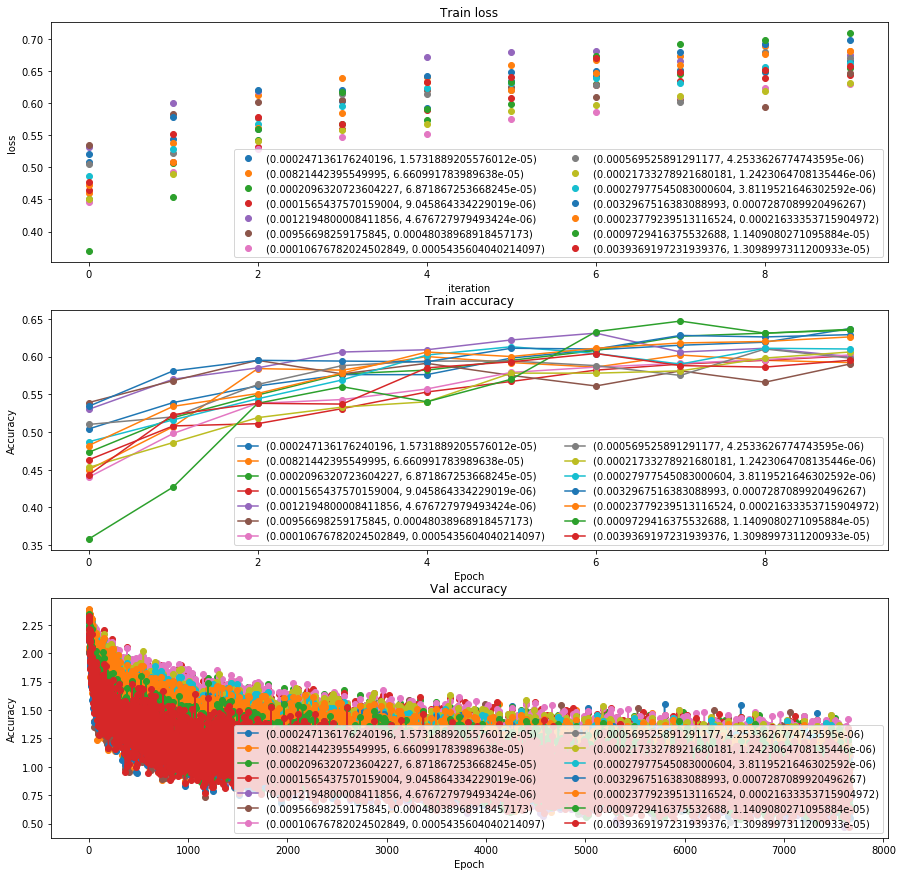

In [33]:
views.compare_trainings(train_stats)

## 4.2 example dropout model

In [ ]:
# find learning rate and regularization that can make the net work
torch.cuda.random.manual_seed(12345)

# model
example_dropout_model = models.ExampleDropoutNet().type(dtype)
example_dropout_loss_fn = nn.CrossEntropyLoss().type(dtype)

#example_dropout_optimizer = optim.Adam(example_dropout_model.parameters(), lr=1e-3)
example_dropout_optimizer = optim.SGD(example_dropout_model.parameters(), lr=0.002071, momentum=0.9, weight_decay=1e-2)
#example_dropout_optimizer = optim.SGD(example_dropout_model.parameters(), lr=5e-4, momentum=0.9, weight_decay=2e-4)
#example_dropout_optimizer = optim.RMSprop(example_dropout_model.parameters(), lr=1e-4)

example_dropout_exp_lr_scheduler = None
example_dropout_exp_lr_scheduler = lr_scheduler.StepLR(example_dropout_optimizer, step_size=5, gamma=0.7)

example_dropout_solver = solver.ClassificationSolver(loader_train=loader_train, loader_val=loader_val,
                                     model=example_dropout_model,
                                     loss_fn=example_dropout_loss_fn,
                                     optimizer=example_dropout_optimizer,
                                     scheduler=example_dropout_exp_lr_scheduler,
                                     dtype=dtype,
                                     num_epochs=20, verbose=True)

example_dropout_solver.train()

t = 0, loss = 2.3049
t = 100, loss = 1.6997
t = 200, loss = 1.2959
t = 300, loss = 1.4822
t = 400, loss = 1.4296
t = 500, loss = 1.6427
t = 600, loss = 1.5143
t = 700, loss = 1.3498
(Epoch 0 / 20) train acc: 0.557617; val acc: 0.549000
t = 0, loss = 1.3237
t = 100, loss = 1.3534
t = 200, loss = 1.0293
t = 300, loss = 1.3055
t = 400, loss = 1.2089
t = 500, loss = 1.3465
t = 600, loss = 1.2711
t = 700, loss = 1.1816
(Epoch 1 / 20) train acc: 0.537109; val acc: 0.506000
t = 0, loss = 1.1400
t = 100, loss = 1.1515
t = 200, loss = 0.7767
t = 300, loss = 1.0573
t = 400, loss = 1.0802
t = 500, loss = 1.3560
t = 600, loss = 1.0769
t = 700, loss = 1.0285
(Epoch 2 / 20) train acc: 0.593750; val acc: 0.572000
t = 0, loss = 1.0252
t = 100, loss = 1.0630
t = 200, loss = 0.6928
t = 300, loss = 0.9640
t = 400, loss = 1.0271
t = 500, loss = 1.2464
t = 600, loss = 0.9381
t = 700, loss = 0.9351
(Epoch 3 / 20) train acc: 0.688477; val acc: 0.645000
t = 0, loss = 0.9026
t = 100, loss = 0.9536
t = 200, los

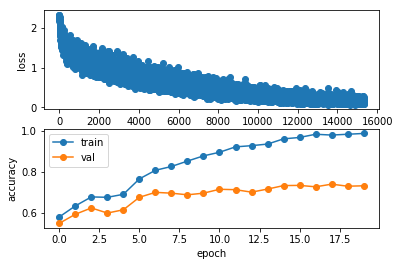

In [63]:
show_solver_training(example_dropout_solver)

In [47]:
import numpy as np
train_stats = {}

# model
#example_dropout_model = models.ExampleDropoutNet().type(dtype)
example_dropout_loss_fn = nn.CrossEntropyLoss().type(dtype)
num_epochs = 10

max_count = 100
for count in range(max_count):
    #lr = 10**np.random.uniform(-3, -2)
    lr = np.random.uniform(0, 5) * 1e-3
    reg = 10**np.random.uniform(-5, -3)
    
    # for saving memory?
    example_dropout_model.apply(reset)
    example_dropout_optimizer = optim.SGD(example_dropout_model.parameters(), lr=lr, momentum=0.9, weight_decay=reg)
    example_dropout_exp_lr_scheduler = None
    
    example_dropout_solver = solver.ClassificationSolver(loader_train=loader_train, loader_val=loader_val,
                                     model=example_dropout_model,
                                     loss_fn=example_dropout_loss_fn,
                                     optimizer=example_dropout_optimizer,
                                     scheduler=example_dropout_exp_lr_scheduler,
                                     dtype=dtype,
                                     num_epochs=num_epochs, verbose=False)
    example_dropout_solver.train()
    train_stats[(lr, reg)] = (example_dropout_solver.loss_history,
                              example_dropout_solver.train_acc_history, 
                              example_dropout_solver.val_acc_history)
    
    print('val accuracy: %f, train accuracy: %f, final loss: %f, lr: %f, reg: %f' % (
        example_dropout_solver.val_acc_history[-1], example_dropout_solver.train_acc_history[-1], example_dropout_solver.loss_history[-1], lr, reg))

KeyboardInterrupt: 